# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# загрузка данных с метками возрастов и выведем первые 5 строк
labels = pd.read_csv('/datasets/faces/labels.csv')
# извлечение данных из папки
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    seed=12345
)
labels.head()

Found 7591 validated image filenames.


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
# выведем размер выборки
print(f"Размер выборки: {labels.shape[0]} изображений")

Размер выборки: 7591 изображений


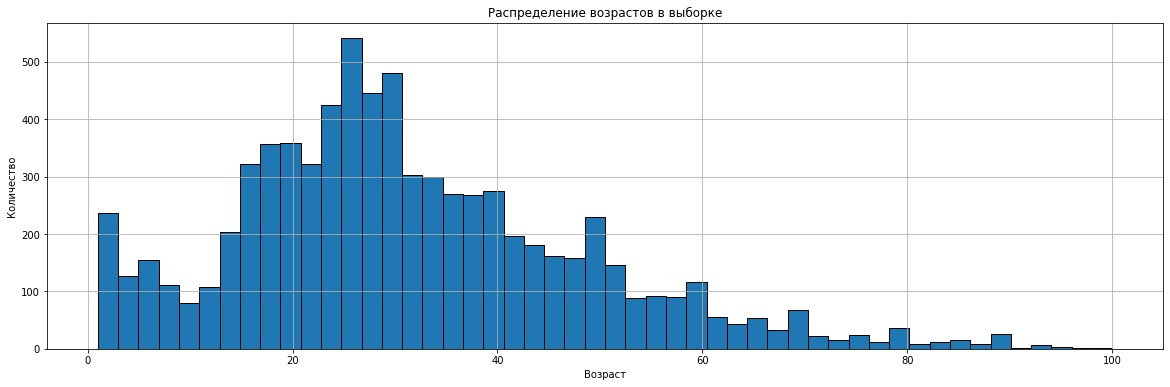

In [4]:
# Гистограмма распределения
plt.figure(figsize=(20, 6))
labels['real_age'].hist(bins=50, edgecolor='black')
plt.title('Распределение возрастов в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Выборка состоит из 7591 изображения. По гистограмме распределения видно, что возраст в выборке распределён неравномерно, с явным пиком около 20–30 лет. Количество наблюдений резко падает для более старших возрастов (старше 60 лет).

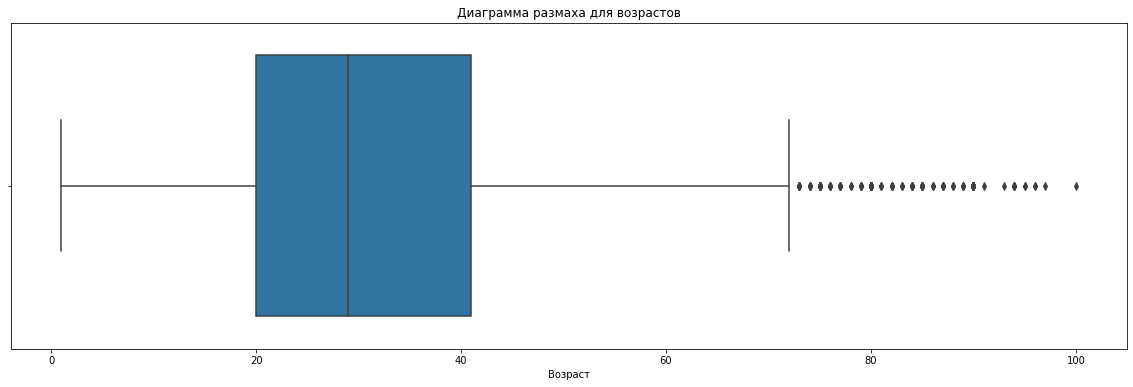

In [5]:
# Диаграмма размаха
plt.figure(figsize=(20, 6))
sns.boxplot(x=labels['real_age'])
plt.title('Диаграмма размаха для возрастов')
plt.xlabel('Возраст')
plt.show()

По диаграаме размаха можем сказать, что основная масса возрастов лежит в пределах от 0 до примерно 70 лет. Наблюдаются выбросы для возрастов старше 70 лет, что характерно для реальных данных. Медиана (средний возраст) лежит около 28 лет.

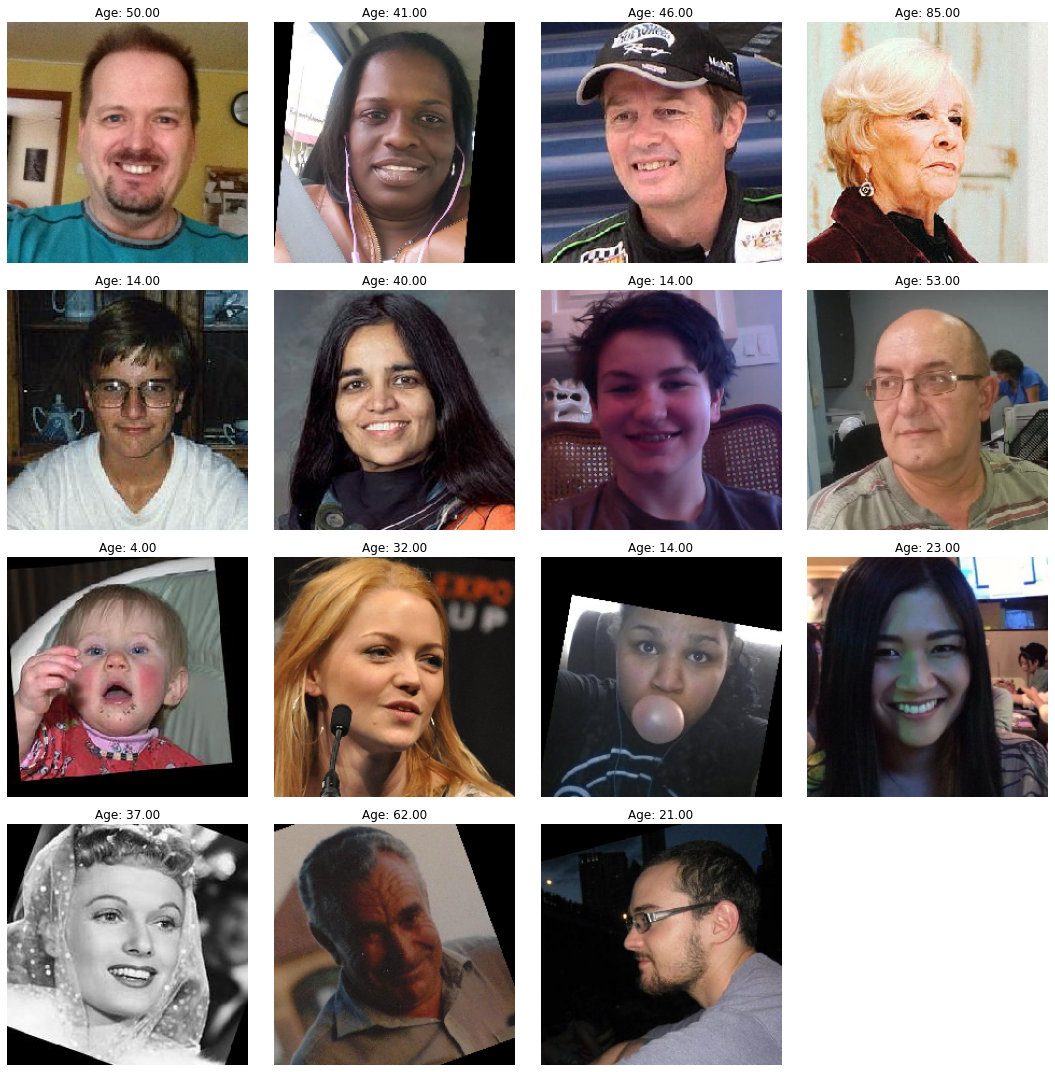

In [6]:
# получение первого батча изображений
features, target = next(train_gen_flow)

# выводим 15 изображений из первого батча
fig = plt.figure(figsize=(15,15))
for i in range(15):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(features[i])
    ax.set_title(f"Age: {target[i]:.2f}") 
    ax.axis('off')
plt.tight_layout()
plt.show()

Выборка включает изображения с людьми разных возрастов, от детей 4 лет до пожилых людей 85 лет. Качество данных визуально выглядит приемлемым: лица четко различимы, имеются различные ракурсы, возрастные особенности визуально соответствуют меткам.

При обучении модели нужно учитывать дисбаланс выборки, изображений людей старше 70 лет крайне мало.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Epoch 1/10

356/356 - 56s - loss: 216.1531 - mae: 11.0945 - val_loss: 328.7392 - val_mae: 13.4576

Epoch 2/10

356/356 - 42s - loss: 136.7275 - mae: 8.9257 - val_loss: 235.9075 - val_mae: 11.6485

Epoch 3/10

356/356 - 43s - loss: 116.5956 - mae: 8.2378 - val_loss: 152.8832 - val_mae: 9.2772

Epoch 4/10

356/356 - 43s - loss: 96.0242 - mae: 7.4656 - val_loss: 148.6918 - val_mae: 9.1400

Epoch 5/10

356/356 - 43s - loss: 85.7568 - mae: 7.0615 - val_loss: 120.5941 - val_mae: 8.2427

Epoch 6/10

356/356 - 42s - loss: 71.7416 - mae: 6.4489 - val_loss: 114.8158 - val_mae: 8.2465

Epoch 7/10

356/356 - 42s - loss: 59.6031 - mae: 5.9037 - val_loss: 107.6719 - val_mae: 7.8270

Epoch 8/10

356/356 - 42s - loss: 49.7498 - mae: 5.3555 - val_loss: 95.0150 - val_mae: 7.4582

Epoch 9/10

356/356 - 42s - loss: 44.0416 - mae: 5.1117 - val_loss: 81.0623 - val_mae: 6.8931

Epoch 10/10

356/356 - 42s - loss: 35.3238 - mae: 4.5951 - val_loss: 99.2234 - val_mae: 7.5725

## Анализ обученной модели

Данные разделены на тренировочную (75%) и валидационную (25%) выборки с использованием метода validation_split в ImageDataGenerator.
В процессе подготовки данных применены аугментации, такие как горизонтальное отражение (horizontal_flip), а также масштабирование значений пикселей (rescale=1./255), что помогает улучшить обобщающую способность модели.

Использована предобученная архитектура ResNet50, к ResNet50 добавлены слои:

    - GlobalAveragePooling2D для снижения размерности.
    - Полносвязный слой (Dense) с одним выходным нейроном (предсказание возраста) и функцией активации ReLU.
    - Оптимизатор Adam с начальным значением скорости обучения lr=0.0005 выбран для эффективной настройки весов, а функция потерь mean_squared_error помогает минимизировать среднеквадратичную ошибку предсказаний.


Обучение проводилось на 10 эпохах, и метрики улучшались по мере увеличения количества эпох:

Средняя абсолютная ошибка (MAE) на тренировочной выборке снизилась с 11.09 (1-я эпоха) до 4.6 (10-я эпоха).
На валидационной выборке MAE снизилась с 13.46 до 7.57, что свидетельствует об улучшении качества предсказаний. Однако на девятой эпохе метрика МАЕ была еще ниже - 6.89, что возможно свидетельствует о переобучении модели.

Функция потерь (loss) на тренировочной выборке уменьшилась с 216.15 до 35.32.
На валидационной выборке loss уменьшилась с 328.74 до 99.22.

Модель успешно обучается на задачах предсказания возраста. Видно, что с увеличением эпох метрики улучшаются, что говорит об эффективном обучении без явного переобучения за 9 эпох.
